In [1]:
import os
import sys
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal
%matplotlib inline

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
from src.strategy.model import Model
from src.strategy.agent import Agent
from src.strategy.environment import Environment
from src.utils import get_config, read_file
config = get_config.read_yaml()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = len(config['data']['symbols']) * config['data']['num_features']
gamma = config['hyperparameters']['gamma']
gae_lambda = config['hyperparameters']['gae_lambda']
clip_epsilon = config['hyperparameters']['clip_epsilon']
value_loss_coef = config['hyperparameters']['value_loss_coef']
entropy_loss_coef = config['hyperparameters']['entropy_loss_coef']
batch_size = config['hyperparameters']['batch_size']
epochs = config['hyperparameters']['num_epochs']
lr = config['hyperparameters']['learning_rate']
window_size = config['hyperparameters']['window_size']
print(f'input_dim: {input_dim}')
print(f'gamma: {gamma}')
print(f'gae_lambda: {gae_lambda}')
print(f'clip_epsilon: {clip_epsilon}')
print(f'value_loss_coef: {value_loss_coef}')
print(f'entropy_loss_coef: {entropy_loss_coef}')
print(f'batch_size: {batch_size}')
print(f'epochs: {epochs}')
print(f'lr: {lr}')
print(f'window_size: {window_size}')
print(f'device: {device}')

input_dim: 126
gamma: 0.99
gae_lambda: 0.95
clip_epsilon: 0.2
value_loss_coef: 0.5
entropy_loss_coef: 0.01
batch_size: 128
epochs: 50
lr: 0.001
window_size: 72
device: cpu


In [5]:
data = read_file.read_merged_training_data()
data

,"('open', 'ETH')","('high', 'ETH')","('low', 'ETH')","('close', 'ETH')","('volume', 'ETH')","('rsi', 'ETH')","('sma-50', 'ETH')","('sma-100', 'ETH')","('sma-200', 'ETH')","('ema-50', 'ETH')",...,"('volume', 'XLM')","('rsi', 'XLM')","('sma-50', 'XLM')","('sma-100', 'XLM')","('sma-200', 'XLM')","('ema-50', 'XLM')","('ema-100', 'XLM')","('ema-200', 'XLM')","('atr', 'XLM')","('adx', 'XLM')"
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00,1.000000,0.962171,0.986505,0.930535,0.618368,0.904891,0.000000,1.0,1.0,0.887498,...,0.215989,1.000000,0.004091,0.141368,0.999997,0.466309,0.580954,0.298796,0.257085,0.325054
2020-10-01 01:00:00,0.922741,1.000000,0.971660,1.000000,0.374792,1.000000,0.073192,1.0,1.0,1.000000,...,0.002807,1.000000,0.061674,0.203590,0.999997,0.638343,0.796008,0.415248,0.064341,0.406695
2020-10-01 02:00:00,1.000000,1.000000,1.000000,1.000000,0.968396,1.000000,0.151500,1.0,1.0,1.000000,...,0.647335,1.000000,0.121460,0.268277,0.999998,0.869845,0.999995,0.577327,0.249065,0.519852
2020-10-01 03:00:00,1.000000,0.932530,1.000000,0.971104,0.200648,0.953461,0.235908,1.0,1.0,1.000000,...,0.615060,0.576580,0.153241,0.303039,0.999998,0.982428,0.999995,0.659771,0.499462,0.568566
2020-10-01 04:00:00,0.970954,1.000000,1.000000,0.969040,0.453046,0.949955,0.318741,1.0,1.0,1.000000,...,0.200664,0.534733,0.182190,0.325396,0.999998,0.999998,0.999996,0.722614,0.372141,0.685574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-29 19:00:00,0.616359,0.535242,0.735184,0.694987,0.052053,1.000000,0.664608,1.0,1.0,0.057490,...,0.031134,0.724355,0.999999,0.999999,0.999998,0.999999,0.999999,0.999999,0.637189,1.000000
2024-09-29 20:00:00,0.694987,0.694383,0.623045,0.539578,0.232078,0.798289,0.554950,1.0,1.0,0.042796,...,0.119612,0.470556,0.999999,0.999999,0.999998,0.999999,0.999999,0.999999,0.717075,0.990767
2024-09-29 21:00:00,0.539842,0.566630,0.669531,0.691029,0.062073,0.985836,0.428238,1.0,1.0,0.065734,...,0.041038,0.515497,0.999999,0.999999,0.999998,0.999999,0.999999,0.999999,0.609842,0.982194


In [6]:
model = Model(input_dim).to(device)
model

Model(
  (lstm): LSTM(126, 256, batch_first=True)
  (actor_head): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=20, bias=True)
  )
  (critic_head): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [7]:
h_0, c_0 = model.init_hidden_state(batch_size, device)
h_0.shape

torch.Size([1, 128, 256])

In [8]:
x = []
for _ in range(batch_size):
    y = []
    for i in range(window_size):
        y.append(data.loc[data.index[i + _]])
    x.append(y)
x_t = torch.tensor(x).float().to(device)
print(x_t)
print(x_t.shape)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35432\703557019.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_t = torch.tensor(x).float().to(device)


tensor([[[1.0000, 0.9622, 0.9865,  ..., 0.2988, 0.2571, 0.3251],
         [0.9227, 1.0000, 0.9717,  ..., 0.4152, 0.0643, 0.4067],
         [1.0000, 1.0000, 1.0000,  ..., 0.5773, 0.2491, 0.5199],
         ...,
         [0.8516, 0.7520, 0.8283,  ..., 0.0000, 0.0000, 0.0000],
         [0.8287, 0.6779, 0.5724,  ..., 0.0000, 0.0000, 0.0000],
         [0.6659, 0.4928, 0.4977,  ..., 0.0000, 0.0122, 0.0000]],

        [[0.9227, 1.0000, 0.9717,  ..., 0.4152, 0.0643, 0.4067],
         [1.0000, 1.0000, 1.0000,  ..., 0.5773, 0.2491, 0.5199],
         [1.0000, 0.9325, 1.0000,  ..., 0.6598, 0.4995, 0.5686],
         ...,
         [0.8287, 0.6779, 0.5724,  ..., 0.0000, 0.0000, 0.0000],
         [0.6659, 0.4928, 0.4977,  ..., 0.0000, 0.0122, 0.0000],
         [0.4777, 0.3929, 0.4252,  ..., 0.0000, 0.0403, 0.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.5773, 0.2491, 0.5199],
         [1.0000, 0.9325, 1.0000,  ..., 0.6598, 0.4995, 0.5686],
         [0.9710, 1.0000, 1.0000,  ..., 0.7226, 0.3721, 0.

In [9]:
mean, std, dist, value, hidden_state = model.forward(x_t, (h_0, c_0))
print(f'dist: {dist}')
print(f'value: {value}')
print(f'hidden state: {hidden_state}')

dist: Normal(loc: torch.Size([128, 10]), scale: torch.Size([128, 10]))
value: tensor([[-0.0201],
        [-0.0241],
        [-0.0229],
        [-0.0239],
        [-0.0253],
        [-0.0298],
        [-0.0317],
        [-0.0335],
        [-0.0338],
        [-0.0294],
        [-0.0224],
        [-0.0224],
        [-0.0244],
        [-0.0263],
        [-0.0239],
        [-0.0228],
        [-0.0265],
        [-0.0291],
        [-0.0307],
        [-0.0356],
        [-0.0340],
        [-0.0309],
        [-0.0282],
        [-0.0269],
        [-0.0274],
        [-0.0248],
        [-0.0269],
        [-0.0296],
        [-0.0301],
        [-0.0264],
        [-0.0250],
        [-0.0218],
        [-0.0150],
        [-0.0146],
        [-0.0118],
        [-0.0106],
        [-0.0054],
        [-0.0037],
        [-0.0034],
        [-0.0054],
        [-0.0053],
        [-0.0053],
        [-0.0065],
        [-0.0078],
        [-0.0113],
        [-0.0141],
        [-0.0170],
        [-0.0193],
        [-

In [10]:
all_means = mean.detach().cpu().numpy().flatten()
all_stds = std.detach().cpu().numpy().flatten()

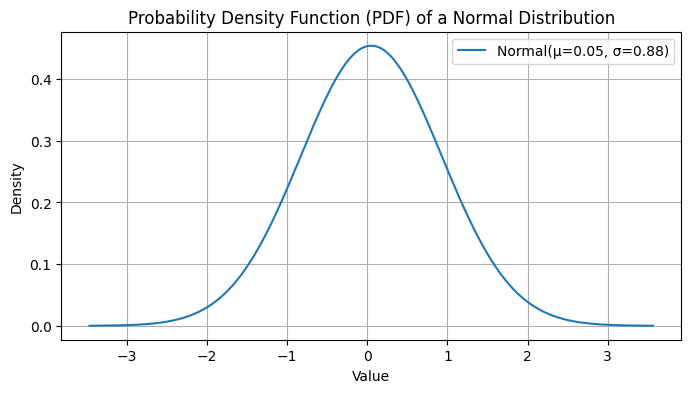

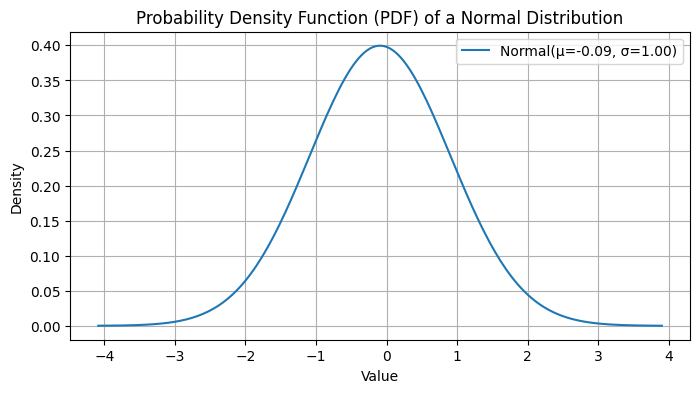

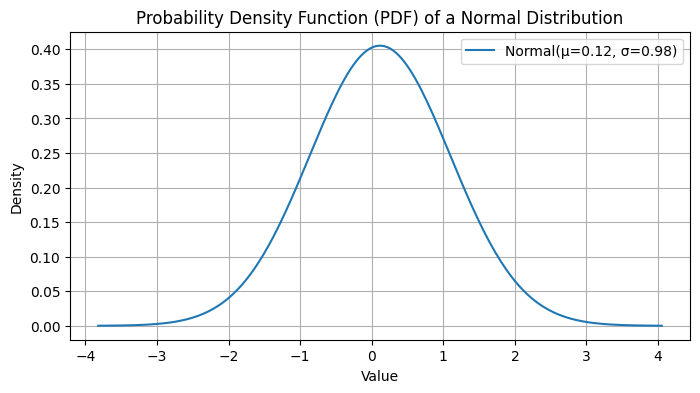

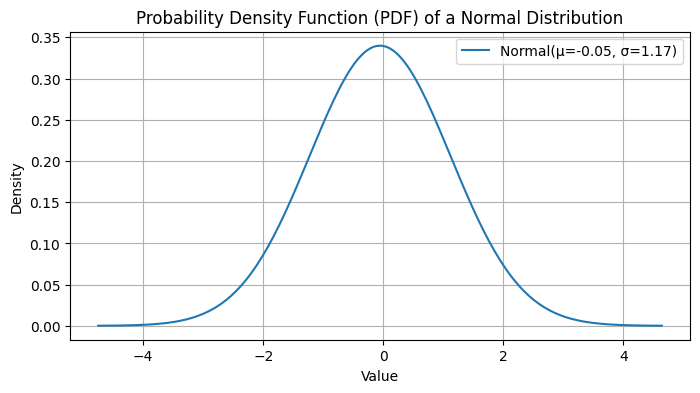

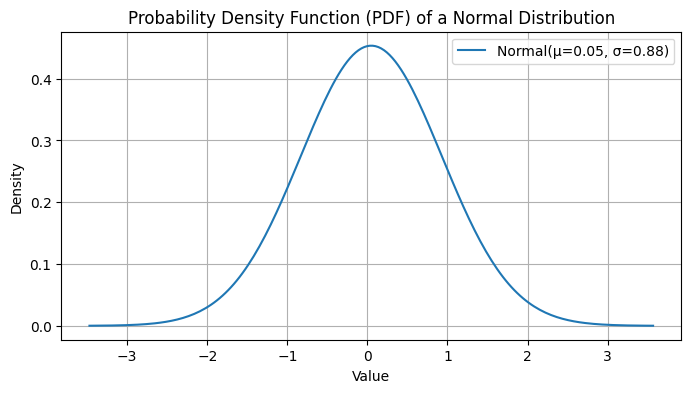

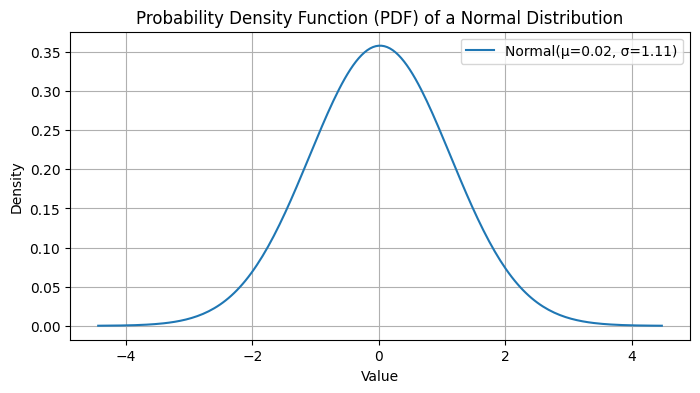

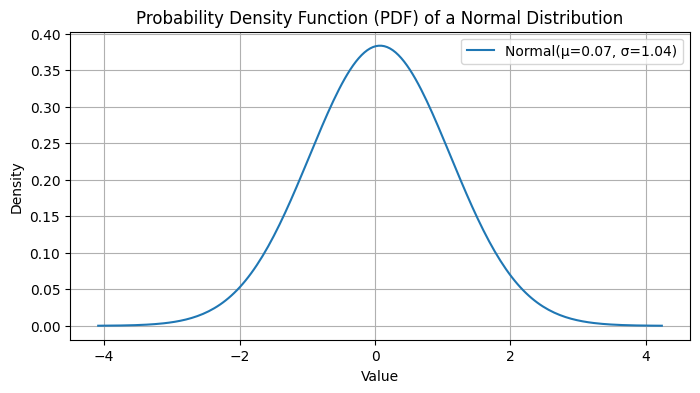

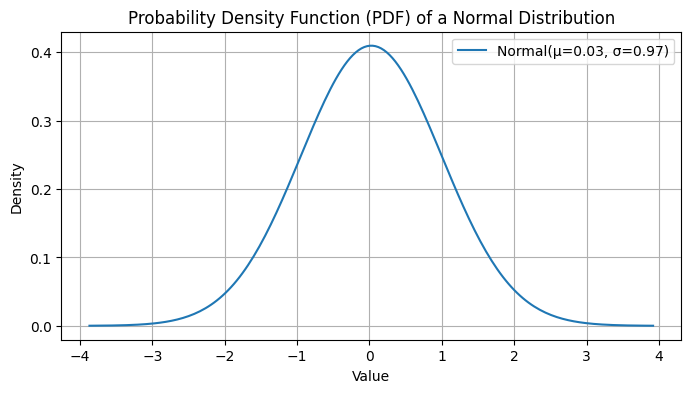

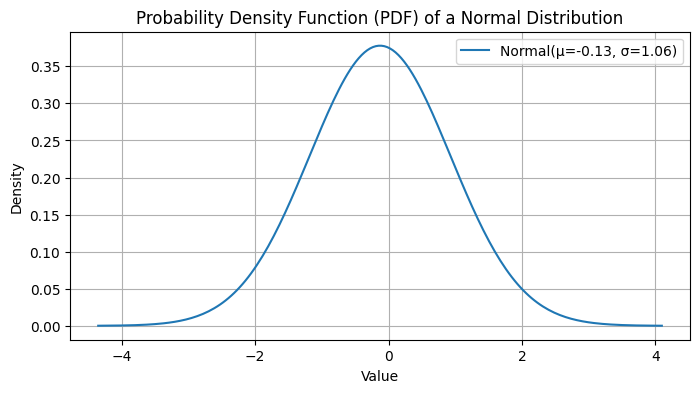

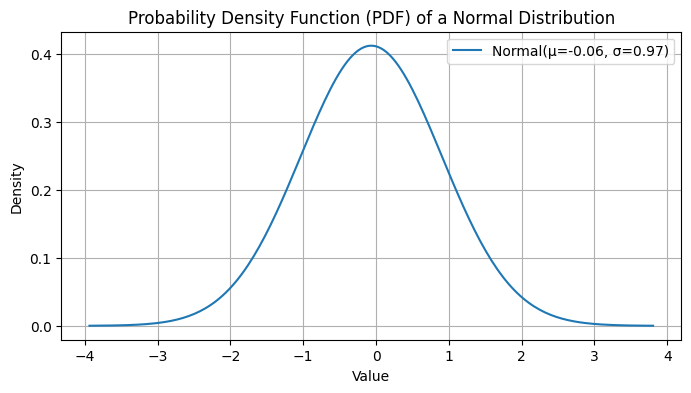

In [11]:
for _ in range(10):
    mea = all_means[_]
    st = all_stds[_]
    dis = Normal(mea, st)
    x_values = torch.linspace(mea - 4 * st, mea + 4 * st, steps=200)
    pdf_values = torch.exp(dis.log_prob(x_values))
    plt.figure(figsize=(8, 4))
    plt.plot(x_values.detach().numpy(), pdf_values.detach().numpy(), label=f'Normal(μ={mea.item():.2f}, σ={st.item():.2f})')
    plt.title('Probability Density Function (PDF) of a Normal Distribution')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    plt.show()

In [12]:
action, log_prob, entropy, value, hidden_state = model.get_action_and_value(x_t, hidden_state=(h_0, c_0))
print(f'action: {action}')
print(f'log_prob: {log_prob}')
print(f'entropy: {entropy}')
print(f'value: {value}')
print(f'hidden state: {hidden_state}')

action: tensor([[-0.1415, -0.2080,  0.8795,  ...,  0.0391,  2.1035, -0.9301],
        [ 0.1669,  0.9310, -0.7711,  ..., -1.1739,  0.2366, -0.7102],
        [ 0.8443, -0.8699, -0.5813,  ...,  1.1659, -2.2694, -0.8037],
        ...,
        [ 0.1880,  0.9928,  0.6634,  ...,  2.2434, -0.4733, -1.1111],
        [-0.0302,  1.8308,  0.5316,  ...,  1.4273, -2.7715, -0.0224],
        [ 1.8034, -0.5186, -1.1019,  ...,  0.4599, -0.6461, -0.1736]])
log_prob: tensor([-15.7451, -14.8321, -13.7469, -11.4055, -15.5788, -12.2028, -11.1321,
        -15.4471, -15.0565, -11.0761, -15.3891, -13.0412, -15.4528, -13.0332,
        -18.1994, -14.1179, -15.3714, -12.1977, -14.4395, -16.9128, -12.6821,
        -12.0994, -17.5540, -13.1621, -16.4912, -13.1536, -14.3913, -13.4620,
        -18.9661, -10.3903, -12.6053, -14.6898, -12.6595, -13.8436, -13.0815,
        -12.8859, -13.3629, -10.7818, -12.7253, -17.4121, -15.2264, -11.7657,
        -12.4127, -14.8102, -13.6491, -12.6124, -14.3052, -11.1996, -12.0641,
  

In [13]:
action[0]

tensor([-0.1415, -0.2080,  0.8795, -2.6772, -1.1404,  0.0608, -0.5009,  0.0391,
         2.1035, -0.9301])

In [21]:
action[0][9] = abs(action[0][9])
long_action = action[0][action[0] >= 0]
print(long_action)
short_action = action[0][action[0] < 0]
print(short_action)
all_action = long_action

tensor([0.8795, 0.0608, 0.0391, 2.1035, 0.9301])
tensor([-0.1415, -0.2080, -2.6772, -1.1404, -0.5009])
